# TEXT ANALYTICS

In [1]:
# Imports required packages

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
import nltk
from nltk import word_tokenize
from nltk.stem.snowball import PorterStemmer

import re, random

import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data Set
The data set consists of sentiments expressed by users on various movies. The dataset is available at https://www.kaggle.com/c/si650winter11/ and was originally contributed by the University of Michigan for building a classiﬁcation model to classify sentiment. 

In [2]:
# Loads the sentiments. Note '\t' was passed as parameter to indicate
# that the sentiment text and labels are seperated by tab character
sentiments = pd.read_csv("./../../../Data/sentiment_train", delimiter = '\t')

# Shows top few sentiments

with pd.option_context("display.max_colwidth", None):
    display(sentiments.head(10))

,sentiment,text
0,1,The Da Vinci Code book is just awesome.
1,1,"this was the first clive cussler i've ever read, but even books like Relic, and Da Vinci code were more plausible than this."
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly didn't seem to hold it's own.
5,1,"that's not even an exaggeration ) and at midnight we went to Wal-Mart to buy the Da Vinci Code, which is amazing of course."
6,1,"I loved the Da Vinci Code, but now I want something better and different!.."
7,1,"i thought da vinci code was great, same with kite runner."
8,1,The Da Vinci Code is actually a good movie...
9,1,I thought the Da Vinci Code was a pretty good book.


In [3]:
# Shows top few negative sentiments
sentiments[sentiments.sentiment == 0].head(10)

,sentiment,text
3943,0,da vinci code was a terrible movie.
3944,0,"Then again, the Da Vinci code is super shitty ..."
3945,0,"The Da Vinci Code comes out tomorrow, which su..."
3946,0,i thought the da vinci code movie was really b...
3947,0,"God, Yahoo Games has this truly-awful looking ..."
3948,0,Da Vinci Code does suck.
3949,0,And better...-We all know Da Vinci code is bog...
3950,0,"Last time, Da Vinci code is also a bit disappo..."
3951,0,And better...-We all know Da Vinci code is bog...
3952,0,And better..-We all know Da Vinci code is bogu...


## Exploratory Data Analysis (EDA)

In [4]:
# Retrives basic information about the data set
sentiments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6918 entries, 0 to 6917
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  6918 non-null   int64 
 1   text       6918 non-null   object
dtypes: int64(1), object(1)
memory usage: 108.2+ KB


In [5]:
# Gets count for positive and negative sentiments
sentiments.sentiment.value_counts()

sentiment
1    3943
0    2975
Name: count, dtype: int64

## Text Preprocessing

### Bag of Words (BoW)

**Creating Count Vectors**

In [6]:
# Initializes CountVectorizer
count_vectorizer = CountVectorizer()

# Creates features vectors (which are sparse in nature)
feature_vectors = count_vectorizer.fit_transform(sentiments.text)

In [7]:
# Prints total number of features
feature_names = count_vectorizer.get_feature_names_out()
print("Total number of features:", len(feature_names))

Total number of features: 2132


In [8]:
# Prints few features randomly
print(random.sample(feature_names.tolist(), 20))

['jame', 'conquering', 'purchase', 'possible', 'shame', 'share', 'colfer', 'nothing', 'characters', 'found', 'whereas', 'full', 'bitter', 'body', 'irrespective', 'getting', 'places', 'does', 'flat', 'live']


In [9]:
# Prints the shape of the feature vectors
print(feature_vectors.shape)

(6918, 2132)


It is sparse matrix as each document has only few words out of the vocabulary (words in dictionary) and hence most of the elements in each of the vector will be zeros.

In [10]:
# Let's calculate how many non-zero values are there in the matrix (calculated as density)

print("Density of the feature vector matrix is {:.2f}%".format(
    feature_vectors.getnnz() / (feature_vectors.shape[0] * feature_vectors.shape[1]) * 100))

Density of the feature vector matrix is 0.44%


**Displaying Document Vectors**

In [11]:
# Stores dense matrix representation for features
feature_vectors_densed = pd.DataFrame(feature_vectors.todense())
feature_vectors_densed.columns = feature_names

In [12]:
# Prints the first sentiment
print(sentiments.text[0])

The Da Vinci Code book is just awesome.


In [13]:
# Prints the dense vector representation for the first sentiment
display(
    feature_vectors_densed[sentiments.text[0].lower().replace('.', '').split(" ")].loc[0:0])

,the,da,vinci,code,book,is,just,awesome
0,1,1,1,1,1,1,1,1


**Removing Low-frequency Words**

In [14]:
# Initializes CountVectorizer by setting limit to features to avoid words that 
# are present only in very few documents

count_vectorizer = CountVectorizer(max_features = 1000)

# Creates features vectors (which are sparse in nature)
feature_vectors = count_vectorizer.fit_transform(sentiments.text)

# Prints total number of features
feature_names = count_vectorizer.get_feature_names_out()

In [15]:
# Counts frequency of the features and prints top 15 most-used words in the documents

display(
    pd.DataFrame(
        {"feature": feature_names, "count": np.sum(feature_vectors.toarray(), axis = 0)}
    ).sort_values("count", ascending = False)[:20]

)

,feature,count
866,the,3306
37,and,2154
358,harry,2093
675,potter,2093
138,code,2002
934,vinci,2001
178,da,2001
528,mountain,2000
104,brokeback,2000
488,love,1624


**Removing Stop Words**

In [16]:
# prints few of the stop words
print(list(text.ENGLISH_STOP_WORDS)[:10])

['may', 'get', 'neither', 'itself', 'almost', 'everyone', 'myself', 'thus', 'thru', 'bottom']


In [17]:
# Adding few of the domain specific words as stop words
stop_words = text.ENGLISH_STOP_WORDS.union(
    ["harry", "potter", "code", "vinci", "da", "harry", "mountain", "movie", "movies"])

In [18]:
# Once again, initializes CountVectorizer, but this time passing stop words as parameter

count_vectorizer = CountVectorizer(stop_words = list(stop_words), max_features = 1000)

# Creates features vectors (which are sparse in nature)
feature_vectors = count_vectorizer.fit_transform(sentiments.text)

# Prints total number of features
feature_names = count_vectorizer.get_feature_names_out()

# Counts frequency of the features and prints top 15 most-used words in the documents
display(
    pd.DataFrame(
        {"feature": feature_names, "count": np.sum(feature_vectors.toarray(), axis = 0)}
    ).sort_values("count", ascending = False)[:20]

)

,feature,count
73,brokeback,2000
408,love,1624
39,awesome,1127
436,mission,1094
341,impossible,1093
390,like,974
745,sucks,602
743,sucked,600
297,hate,578
652,really,374


**Stemming & Lemmatization**

From above list, it was noticed that different forms of same word appeas in the list and vectorizer treat each of them as a feature and creates feature vector accordingly. Instead words having similar meaning can be considered as a root word. _Stemming_ and _Lemmatization_ are the two relevant techniques to deal with this.

In [19]:
# Instantiates stemmer
stemmer = PorterStemmer()

# Instantiates analyzer object for document tokentization to be used in stemming
analyzer = CountVectorizer().build_analyzer()

In [20]:
# Once again, initializes CountVectorizer, but this time passing an analyser as parameter to stem words
count_vectorizer = CountVectorizer(
    analyzer=lambda doc: [word for word in [stemmer.stem(word) for word in analyzer(doc)] \
                          if word not in list(stop_words)],
    max_features = 1000
)

# Creates features vectors (which are sparse in nature)
feature_vectors = count_vectorizer.fit_transform(sentiments.text)

# Prints total number of features
feature_names = count_vectorizer.get_feature_names_out()

# Counts frequency of the features and prints top 15 most-used words in the documents
display(
    pd.DataFrame(
        {"feature": feature_names, "count": np.sum(feature_vectors.toarray(), axis = 0)}
    ).sort_values("count", ascending = False)[:20]

)

,feature,count
303,harri,2093
83,brokeback,2000
414,love,1883
791,suck,1484
922,wa,1176
400,like,1155
447,movi,1149
45,awesom,1130
441,mission,1094
351,imposs,1093


It can be noted from the above list that the applicable words have stemmed into their root forms.

**Word Distribution Across Sentiments**

Checks distributions of words having positive and negative meaning across documents of diffenent sentiments to get an estimate of how these words could be a features for predicting sentiments of documents.

In [21]:
# Stores dense matrix representation for features
feature_vectors_densed = pd.DataFrame(feature_vectors.todense())

# Sets the feature names as column names
feature_vectors_densed.columns = feature_names

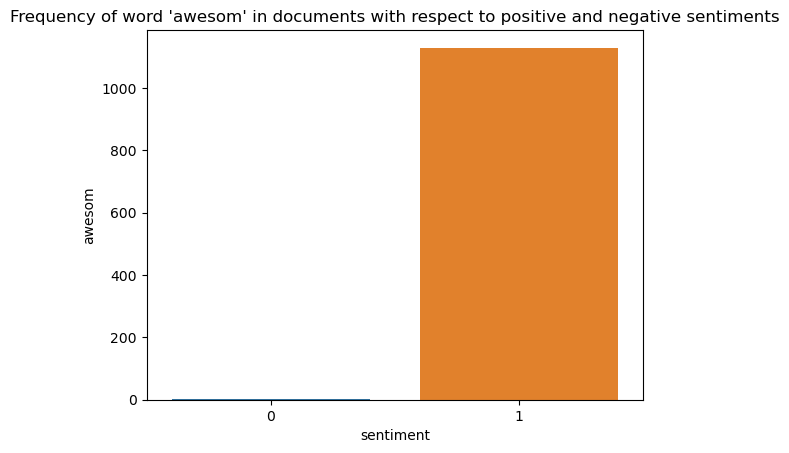

In [22]:
# shows the frequency of positive word 'awesom' in documents 
# with respect to positive and negative sentiments
sns.barplot(x = sentiments.sentiment, y = "awesom", 
            data = feature_vectors_densed, estimator=sum, errorbar=None)
plt.title("Frequency of word 'awesom' in documents " \
          "with respect to positive and negative sentiments")
plt.show()

As shown above, the word _awesom_ (stemmed word for _awesome_) appears mostly in positive sentiment documents.

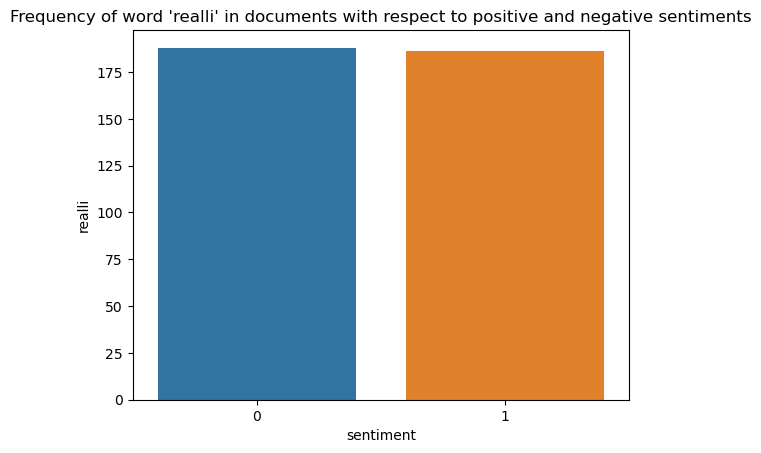

In [23]:
# Similarly, shows the frequency of neutral word 'realli' in documents 
# with respect to positive and negative sentiments
sns.barplot(x = sentiments.sentiment, y = "realli", 
            data = feature_vectors_densed, estimator=sum, errorbar=None)
plt.title("Frequency of word 'realli' in documents " \
          "with respect to positive and negative sentiments")
plt.show()

As shown in the above figure, the word _realli_ (stemmed word for _really_) occurs almost equally across positive and negative sentiments.

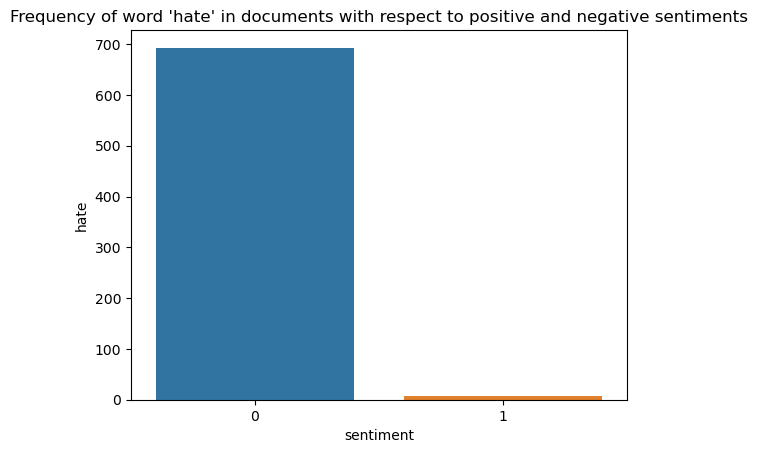

In [24]:
# Now, shows the frequency of negative word 'hate' in documents 
# with respect to positive and negative sentiments
sns.barplot(x = sentiments.sentiment, y = "hate", 
            data = feature_vectors_densed, estimator=sum, errorbar=None)
plt.title("Frequency of word 'hate' in documents " \
          "with respect to positive and negative sentiments")
plt.show()

The above figure shows that word _hate_ occurs mostly in negative sentiments than positive sentiments.

## Modeling

In [25]:
# Prepares data set for training and testing
train_X, test_X, train_y, test_y = train_test_split(
    feature_vectors, sentiments.sentiment, test_size = 0.3, 
    stratify = sentiments.sentiment, random_state = 42)

### Text Classification using Naive-Bayes Models

To predict if a document having a specific word is of positive or negative sentiment, then the expression using Naive-Bayes model is as shown below.

$P(doc = +ve | word = w_1) = P(word = w_1 | doc = +ve) * P(doc = +ve)$

And, to predict of a documents having more than one word of interest, the the expression could be 

$P(doc = +ve | word = w_1, w_2, ..., w_n) = \prod_{i=1}^n{P_i(word = w_i | doc = +ve) * P(doc = +ve)}$

In [26]:
# Instantiate classifier
bernoulli_nb_clf = BernoulliNB()

# Fits the model
bernoulli_nb_clf.fit(train_X.toarray(), train_y)

# Performs predictions
predictions = bernoulli_nb_clf.predict(test_X.toarray())

**Measure Model Performance**

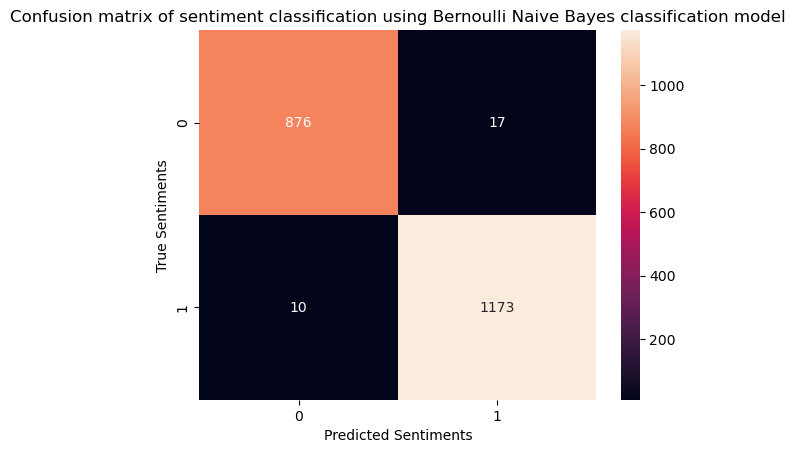

In [27]:
# Creates confusion matrix
conf_matrix = confusion_matrix(test_y, predictions)

sns.heatmap(conf_matrix, annot = True, fmt = ".0f");
plt.ylabel("True Sentiments")
plt.xlabel("Predicted Sentiments")
plt.title("Confusion matrix of sentiment classiﬁcation using " \
          "Bernoulli Naive Bayes classification model")
plt.show()

In [28]:
# Prints classification report
print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       893
           1       0.99      0.99      0.99      1183

    accuracy                           0.99      2076
   macro avg       0.99      0.99      0.99      2076
weighted avg       0.99      0.99      0.99      2076



### Text Classification using TF-IDF Vectorizer

In [29]:
# Initializes IF-IDF vectorizer
tf_idf_vectorizer = TfidfVectorizer(
    analyzer=lambda doc: [word for word in [stemmer.stem(word) for word in analyzer(doc)] \
                          if word not in list(stop_words)],
    max_features = 1000
)

# Creates features vectors (which are sparse in nature)
feature_vectors = tf_idf_vectorizer.fit_transform(sentiments.text)

# Prints total number of features
feature_names = tf_idf_vectorizer.get_feature_names_out()


As TF-IDF are continious values and these values are considered to be of Gaussian distribution, Gaussian Naive Bayes classifier is used classify the documents.


In [30]:
# Prepares data set for training and testing
train_X, test_X, train_y, test_y = train_test_split(
    feature_vectors, sentiments.sentiment, test_size = 0.3, 
    stratify = sentiments.sentiment, random_state = 42)

In [31]:
# Instantiate classifier
gaussian_nb_clf = GaussianNB()

# Fits the model
gaussian_nb_clf.fit(train_X.toarray(), train_y)

# Performs predictions
predictions = gaussian_nb_clf.predict(test_X.toarray())

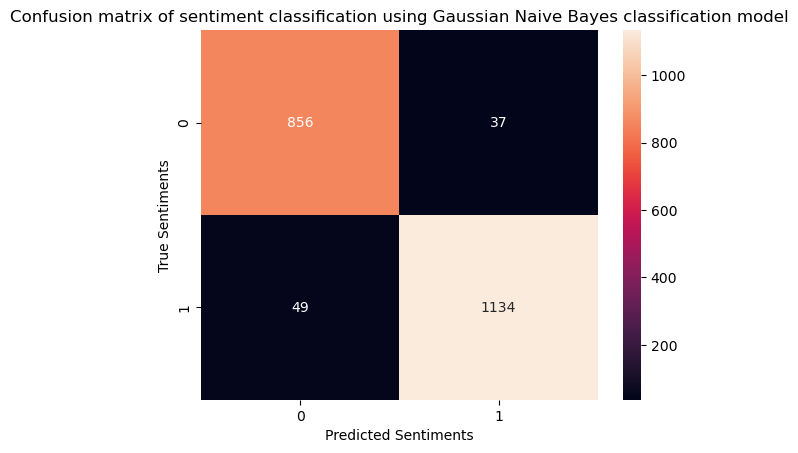

In [32]:
# Creates confusion matrix
conf_matrix = confusion_matrix(test_y, predictions)

sns.heatmap(conf_matrix, annot = True, fmt = ".0f");
plt.ylabel("True Sentiments")
plt.xlabel("Predicted Sentiments")
plt.title("Confusion matrix of sentiment classiﬁcation using " \
          "Gaussian Naive Bayes classification model")
plt.show()

In [33]:
# Prints classification report
print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       893
           1       0.97      0.96      0.96      1183

    accuracy                           0.96      2076
   macro avg       0.96      0.96      0.96      2076
weighted avg       0.96      0.96      0.96      2076



### Text Classification using N-Gram

In [43]:
# The following statement downloads the NLTK specific punctuations 
# resources; It needs to be executed only once and will get cached for later use.
# Note that this step may take several minutes to complete.

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/pradip/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [34]:
# Sets n for n-gram
n_gram_range = (1, 2)

# Initializes IF-IDF vectorizer
tf_idf_vectorizer = TfidfVectorizer(
    tokenizer = lambda doc: [word for word in \
                             [stemmer.stem(word) for word in \
                              [word for word in word_tokenize(doc) if re.search('[a-zA-Z]', word) is not None]]],
    stop_words = list(stop_words), # or "english"
    ngram_range = n_gram_range,
    max_features = 1000
)

In [35]:

# Creates features vectors (which are sparse in nature)
feature_vectors = tf_idf_vectorizer.fit_transform(sentiments.text)

# Prints total number of features
feature_names = tf_idf_vectorizer.get_feature_names_out()

/home/pradip/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/pradip/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'harri', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'movi', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'the

In [36]:
# Prepares data set for training and testing
train_X, test_X, train_y, test_y = train_test_split(
    feature_vectors, sentiments.sentiment, test_size = 0.3, 
    stratify = sentiments.sentiment, random_state = 42)

In [37]:
# Instantiate classifier
bernoulli_nb_clf = BernoulliNB()

# Fits the model
bernoulli_nb_clf.fit(train_X.toarray(), train_y)

# Performs predictions
predictions = bernoulli_nb_clf.predict(test_X.toarray())

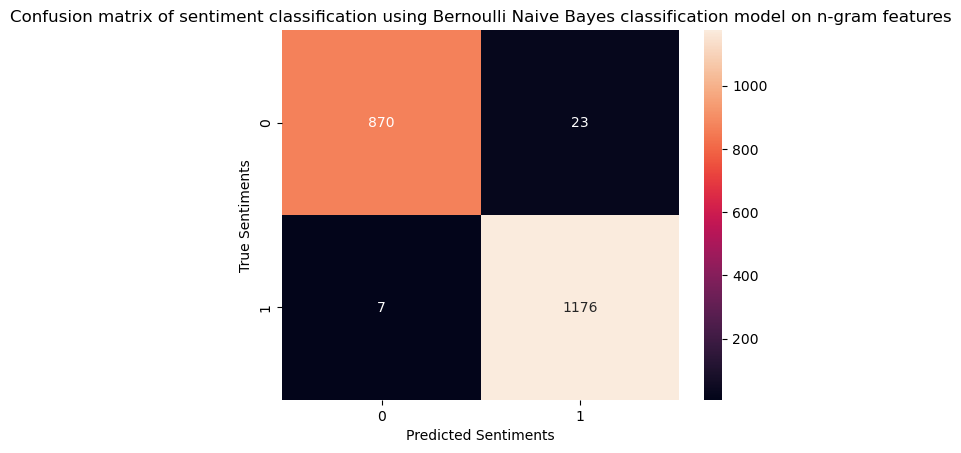

In [38]:
# Creates confusion matrix
conf_matrix = confusion_matrix(test_y, predictions)

sns.heatmap(conf_matrix, annot = True, fmt = ".0f");
plt.ylabel("True Sentiments")
plt.xlabel("Predicted Sentiments")
plt.title("Confusion matrix of sentiment classiﬁcation using " \
          "Bernoulli Naive Bayes classification model on n-gram features")
plt.show()

In [39]:
# Prints classification report
print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       893
           1       0.98      0.99      0.99      1183

    accuracy                           0.99      2076
   macro avg       0.99      0.98      0.99      2076
weighted avg       0.99      0.99      0.99      2076



Note that recall for positive sentiments has increased nearly to 100%.